In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

In [90]:
df = pd.read_excel('all.xlsx')


print(df.head())

        Data          V     T  id
0 2010-01-01  30.972282   7.0   3
1 2010-01-02  29.846362  10.0   3
2 2010-01-03  36.359652   6.0   3
3 2010-01-04  41.859071  -1.0   3
4 2010-01-05  43.567304  -6.0   3


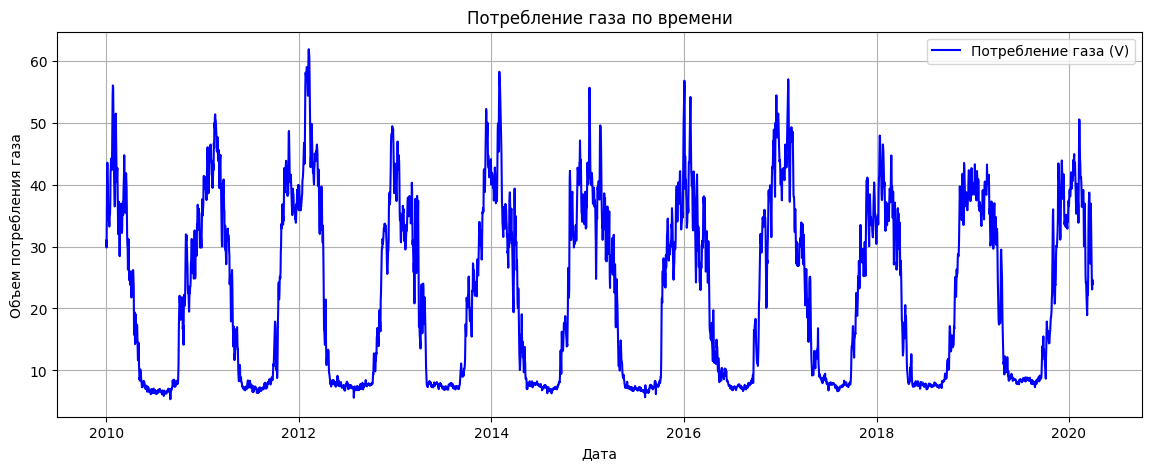

In [91]:
plt.figure(figsize=(14,5))
plt.plot(df['Data'], df['V'], label='Потребление газа (V)', color='blue')
plt.title('Потребление газа по времени')
plt.xlabel('Дата')
plt.ylabel('Объем потребления газа')
plt.grid(True)
plt.legend()
plt.show()

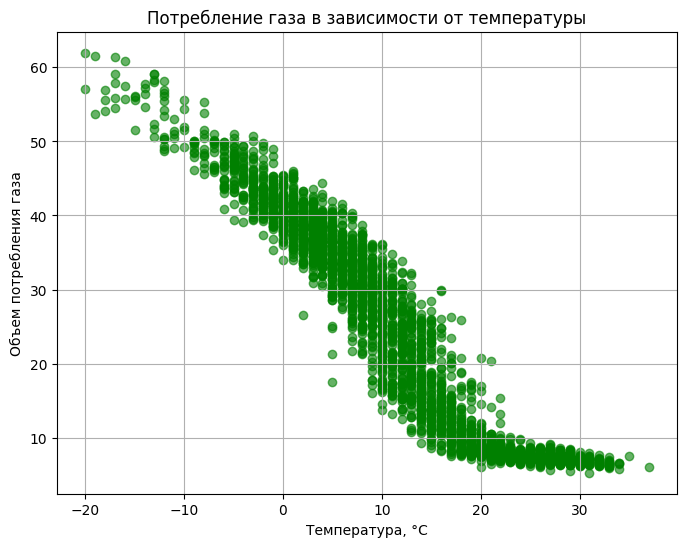

In [92]:
plt.figure(figsize=(8,6))
plt.scatter(df['T'], df['V'], alpha=0.6, color='green')
plt.title('Потребление газа в зависимости от температуры')
plt.xlabel('Температура, °C')
plt.ylabel('Объем потребления газа')
plt.grid(True)
plt.show()

Снижение температуры → увеличение потребления


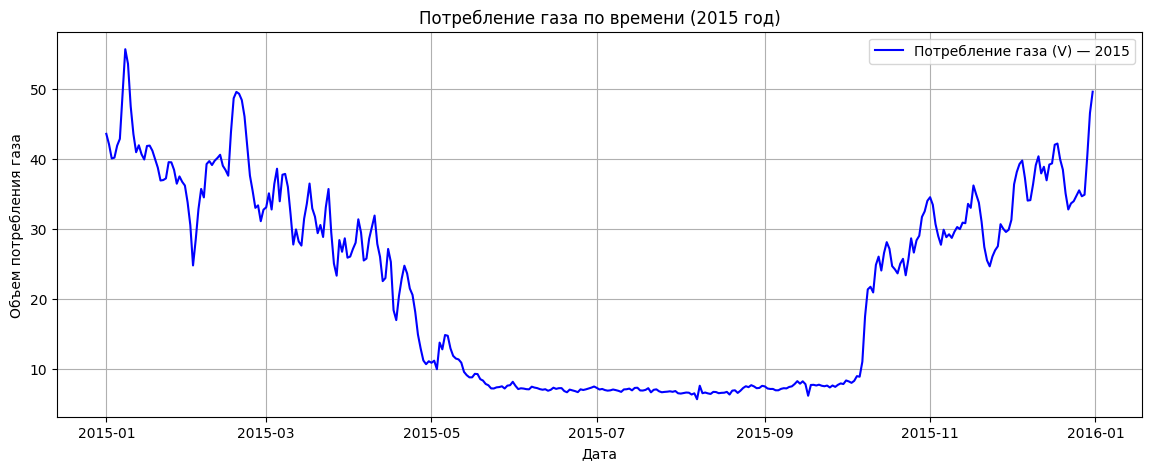

In [93]:

df_2015 = df[df['Data'].dt.year == 2015]

# Построение графика
plt.figure(figsize=(14,5))
plt.plot(df_2015['Data'], df_2015['V'], label='Потребление газа (V) — 2015', color='blue')
plt.title('Потребление газа по времени (2015 год)')
plt.xlabel('Дата')
plt.ylabel('Объем потребления газа')
plt.grid(True)
plt.legend()
plt.show()

<Figure size 1000x600 with 0 Axes>

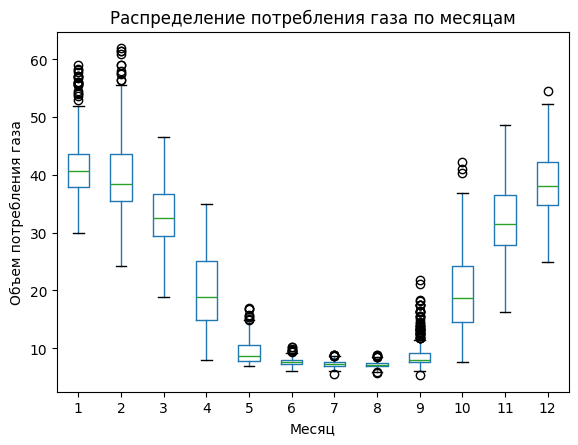

In [94]:
df['month'] = df['Data'].dt.month

plt.figure(figsize=(10,6))
df.boxplot(column='V', by='month', grid=False)
plt.title('Распределение потребления газа по месяцам')
plt.suptitle('')
plt.xlabel('Месяц')
plt.ylabel('Объем потребления газа')
plt.show()

In [95]:

df['month'] = pd.to_datetime(df['Data']).dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Зима
    elif month in [3, 4, 5]:
        return 1  # Весна
    elif month in [6, 7, 8]:
        return 2  # Лето
    else:
        return 3  # Осень

df['season'] = df['month'].apply(get_season)


df['is_winter'] = (df['season'] == 0).astype(int)
df['is_spring'] = (df['season'] == 1).astype(int)
df['is_summer'] = (df['season'] == 2).astype(int)
df['is_autumn'] = (df['season'] == 3).astype(int)


df['is_workday']   = (df['id'] == 0).astype(int)
df['is_weekend']   = (df['id'] == 1).astype(int)
df['is_shortday']  = (df['id'] == 2).astype(int)
df['is_holiday']   = (df['id'] == 3).astype(int)


df['V_target'] = df['V'].shift(-2)


df['T_t+1'] = df['T'].shift(-1)
df['T_t+2'] = df['T'].shift(-2)
df['T_t+3'] = df['T'].shift(-3)

df['dayofyear'] = pd.to_datetime(df['Data']).dt.dayofyear


df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


df = df.drop(columns=['id', 'season'])


df_model = df.dropna().reset_index(drop=True)

In [96]:
df_model

,Data,V,T,month,is_winter,is_spring,is_summer,is_autumn,is_workday,is_weekend,is_shortday,is_holiday,V_target,T_t+1,T_t+2,T_t+3,dayofyear,sin_dayofyear,cos_dayofyear
0,2010-01-01,30.972282,7.0,1,1,0,0,0,0,0,0,1,36.359652,10.0,6.0,-1.0,1,0.017213,0.999852
1,2010-01-02,29.846362,10.0,1,1,0,0,0,0,0,0,1,41.859071,6.0,-1.0,-6.0,2,0.034422,0.999407
2,2010-01-03,36.359652,6.0,1,1,0,0,0,0,0,0,1,43.567304,-1.0,-6.0,-2.0,3,0.051620,0.998667
3,2010-01-04,41.859071,-1.0,1,1,0,0,0,0,0,0,1,41.690585,-6.0,-2.0,0.0,4,0.068802,0.997630
4,2010-01-05,43.567304,-6.0,1,1,0,0,0,0,0,0,1,39.604016,-2.0,0.0,6.0,5,0.085965,0.996298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3735,2020-03-24,36.935206,2.0,3,0,1,0,0,1,0,0,0,30.091080,7.0,8.0,10.0,84,0.992222,0.124479
3736,2020-03-25,33.623717,7.0,3,0,1,0,0,1,0,0,0,27.265757,8.0,10.0,12.0,85,0.994218,0.107381
3737,2020-03-26,30.091080,8.0,3,0,1,0,0,1,0,0,0,23.839776,10.0,12.0,12.0,86,0.995919,0.090252
3738,2020-03-27,27.265757,10.0,3,0,1,0,0,1,0,0,0,23.060885,12.0,12.0,11.0,87,0.997325,0.073095


In [97]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [98]:

data = df_model.copy()


target_col = 'V_target'


features = [col for col in data.columns if col not in ['Data', 'V_target']]


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[[target_col]])


seq_len = 7


X_seq = []
y_seq = []

for i in range(seq_len, len(X_scaled)):
    X_seq.append(X_scaled[i-seq_len:i])
    y_seq.append(y_scaled[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)


In [99]:
class GasDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_size = int(len(X_seq) * 0.97)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


train_dataset = GasDataset(X_train, y_train)
test_dataset = GasDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [100]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [101]:
model = RNNModel(input_size=X_train.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}")


Epoch 1/50, Loss: 1.0683
Epoch 11/50, Loss: 0.1360
Epoch 21/50, Loss: 0.0931
Epoch 31/50, Loss: 0.0863
Epoch 41/50, Loss: 0.0874
Epoch 50/50, Loss: 0.0780


In [102]:
model.eval()
with torch.no_grad():
    preds = []
    true = []
    for X_batch, y_batch in test_loader:
        output = model(X_batch).squeeze()
        preds.append(output.numpy())
        true.append(y_batch.squeeze().numpy())


y_pred_r = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1)).flatten()
y_true_r= scaler_y.inverse_transform(np.concatenate(true).reshape(-1, 1)).flatten()


mape = mean_absolute_percentage_error(y_true_r, y_pred_r) * 100
rmse = np.sqrt(mean_squared_error(y_true_r, y_pred_r))

print(f" MAPE: {mape:.2f}%")
print(f" RMSE: {rmse:.2f}")


 MAPE: 3.78%
 RMSE: 1.74


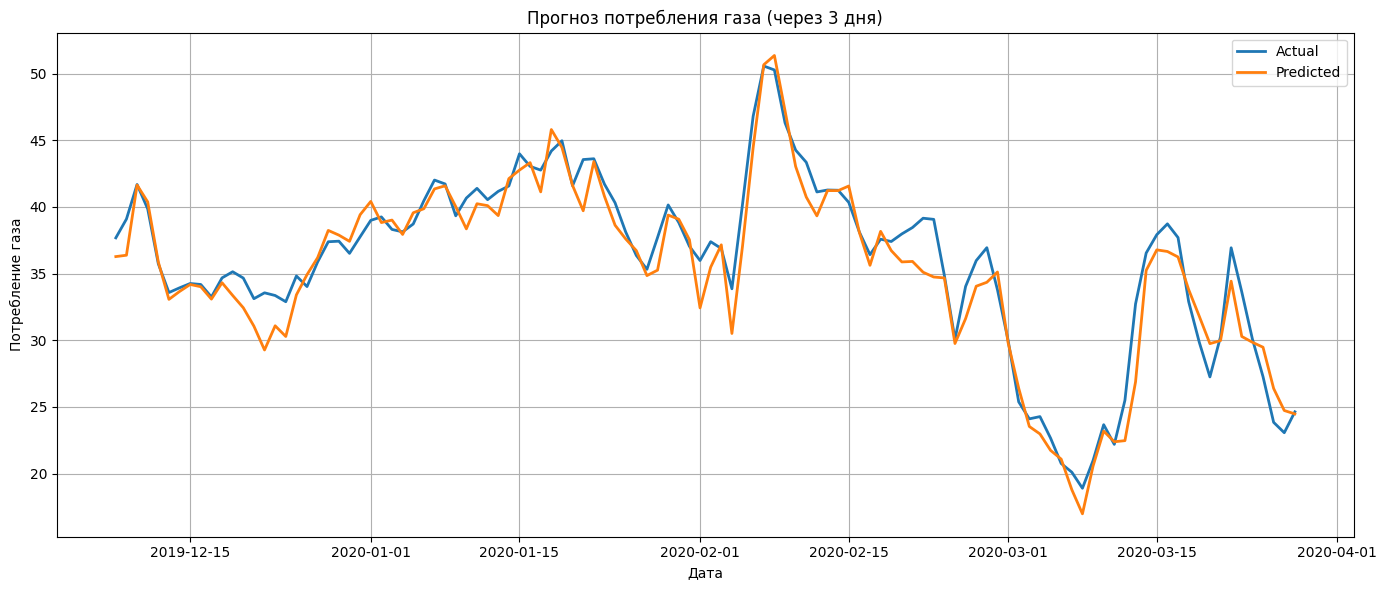

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


test_dates = df_model['Data'][-len(y_true_r):].reset_index(drop=True)


results_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates),
    'Actual': y_true_r,
    'Predicted': y_pred_r
})


plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', linewidth=2)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', linewidth=2)
plt.title('Прогноз потребления газа (через 3 дня)')
plt.xlabel('Дата')
plt.ylabel('Потребление газа')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [105]:
y_true_r

array([37.67962 , 39.091118, 41.684986, 39.855824, 35.73328 , 33.57795 ,
       33.930233, 34.255413, 34.181477, 33.244812, 34.676434, 35.13737 ,
       34.663704, 33.11497 , 33.556805, 33.355366, 32.888676, 34.82175 ,
       34.025436, 35.873074, 37.388245, 37.430077, 36.516617, 37.760914,
       38.992065, 39.251156, 38.311485, 38.130276, 38.72076 , 40.468163,
       42.0156  , 41.723377, 39.332577, 40.665573, 41.39529 , 40.543835,
       41.16904 , 41.57239 , 43.986965, 43.043507, 42.761906, 44.194965,
       44.965202, 41.587357, 43.554806, 43.614212, 41.710598, 40.310158,
       38.122566, 36.360607, 35.319656, 37.706486, 40.148853, 38.824574,
       37.047207, 35.979244, 37.391937, 36.8822  , 33.858273, 40.214977,
       46.807285, 50.56999 , 50.27596 , 46.313747, 44.26285 , 43.34804 ,
       41.123867, 41.270657, 41.25214 , 40.34061 , 38.116463, 36.419044,
       37.579823, 37.405598, 37.976364, 38.454865, 39.15286 , 39.06808 ,
       34.86648 , 30.067616, 34.034565, 35.971165, 

In [106]:
y_pred_r

array([36.27471 , 36.37686 , 41.64398 , 40.376072, 35.868603, 33.065346,
       33.657448, 34.18326 , 34.01299 , 33.08458 , 34.31387 , 33.35829 ,
       32.436436, 31.055294, 29.267641, 31.083164, 30.280476, 33.404   ,
       34.918877, 36.19381 , 38.238   , 37.88478 , 37.419548, 39.416466,
       40.410923, 38.826237, 39.01464 , 37.935818, 39.563217, 39.86521 ,
       41.351696, 41.584747, 40.02485 , 38.353683, 40.239677, 40.096973,
       39.3503  , 42.124004, 42.764122, 43.32226 , 41.131027, 45.807438,
       44.45837 , 41.611336, 39.712402, 43.400192, 40.800274, 38.62965 ,
       37.598522, 36.725163, 34.849327, 35.256252, 39.38845 , 39.0777  ,
       37.54321 , 32.42564 , 35.478333, 37.156357, 30.506002, 37.070896,
       44.456734, 50.6688  , 51.362495, 47.222   , 43.035385, 40.741962,
       39.33082 , 41.2246  , 41.223648, 41.56958 , 38.081936, 35.62151 ,
       38.16921 , 36.725433, 35.874306, 35.910927, 35.101936, 34.742115,
       34.67427 , 29.753338, 31.61947 , 34.051228, 

FNN

In [107]:
df = pd.read_excel('all.xlsx')

df['month'] = df['Data'].dt.month
df['month'] = pd.to_datetime(df['Data']).dt.month

def get_season(month):
    if month in [12, 1, 2]:
        return 0  # Зима
    elif month in [3, 4, 5]:
        return 1  # Весна
    elif month in [6, 7, 8]:
        return 2  # Лето
    else:
        return 3  # Осень

df['season'] = df['month'].apply(get_season)


df['is_winter'] = (df['season'] == 0).astype(int)
df['is_spring'] = (df['season'] == 1).astype(int)
df['is_summer'] = (df['season'] == 2).astype(int)
df['is_autumn'] = (df['season'] == 3).astype(int)


df['is_workday']   = (df['id'] == 0).astype(int)
df['is_weekend']   = (df['id'] == 1).astype(int)
df['is_shortday']  = (df['id'] == 2).astype(int)
df['is_holiday']   = (df['id'] == 3).astype(int)


df['V_target'] = df['V'].shift(-3)


df['T_t+1'] = df['T'].shift(-1)
df['T_t+2'] = df['T'].shift(-2)
df['T_t+3'] = df['T'].shift(-3)

df['dayofyear'] = pd.to_datetime(df['Data']).dt.dayofyear


df['sin_dayofyear'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
df['cos_dayofyear'] = np.cos(2 * np.pi * df['dayofyear'] / 365)


df = df.drop(columns=['id', 'season'])


df_model = df.dropna().reset_index(drop=True)
data = df_model.copy()


target_col = 'V_target'




In [108]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

# Создаем копию
df_nn = df_model.copy()

df_nn = df_model.copy()

# Сначала создаем лаги
df_nn['V_t-1'] = df_nn['V'].shift(1)
df_nn['V_t-2'] = df_nn['V'].shift(2)
#df_nn['V_t-3'] = df_nn['V'].shift(3)
#df_nn['V_t-4'] = df_nn['V'].shift(4)
df_nn['T_t-1'] = df_nn['T'].shift(1)
df_nn['T_t-2'] = df_nn['T'].shift(2)
#df_nn['T_t-3'] = df_nn['T'].shift(3)
#df_nn['T_t-4'] = df_nn['T'].shift(4)


df_nn['V_target'] = df_nn['V'].shift(-3)

df_nn = df_nn.dropna().reset_index(drop=True)


features = [col for col in df_nn.columns if col not in ['Data', 'V_target']]


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(df_nn[features])
y_scaled = scaler_y.fit_transform(df_nn[[target_col]])


split = int(len(X_scaled) * 0.97)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]


In [109]:
class GasFNNData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = GasFNNData(X_train, y_train)
test_data = GasFNNData(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [110]:
class FNNModel(nn.Module):
    def __init__(self, input_size):
        super(FNNModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


In [111]:
model = FNNModel(input_size=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 250
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb).squeeze()
        loss = criterion(out, yb.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/250, Loss: 16.1908
Epoch 11/250, Loss: 0.2346
Epoch 21/250, Loss: 0.1278
Epoch 31/250, Loss: 0.0997
Epoch 41/250, Loss: 0.0880
Epoch 51/250, Loss: 0.0817
Epoch 61/250, Loss: 0.0773
Epoch 71/250, Loss: 0.0757
Epoch 81/250, Loss: 0.0716
Epoch 91/250, Loss: 0.0698
Epoch 101/250, Loss: 0.0685
Epoch 111/250, Loss: 0.0688
Epoch 121/250, Loss: 0.0666
Epoch 131/250, Loss: 0.0661
Epoch 141/250, Loss: 0.0650
Epoch 151/250, Loss: 0.0652
Epoch 161/250, Loss: 0.0645
Epoch 171/250, Loss: 0.0648
Epoch 181/250, Loss: 0.0633
Epoch 191/250, Loss: 0.0641
Epoch 201/250, Loss: 0.0627
Epoch 211/250, Loss: 0.0622
Epoch 221/250, Loss: 0.0624
Epoch 231/250, Loss: 0.0619
Epoch 241/250, Loss: 0.0636
Epoch 250/250, Loss: 0.0613


In [112]:
model.eval()
with torch.no_grad():
    preds, true = [], []
    for xb, yb in test_loader:
        out = model(xb).squeeze()
        preds.append(out.numpy())
        true.append(yb.squeeze().numpy())


y_pred_n = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1, 1)).flatten()
y_true_n = scaler_y.inverse_transform(np.concatenate(true).reshape(-1, 1)).flatten()


mape = mean_absolute_percentage_error(y_true_n, y_pred_n) * 100
rmse = np.sqrt(mean_squared_error(y_true_n, y_pred_n))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


MAPE: 3.84%
RMSE: 1.61


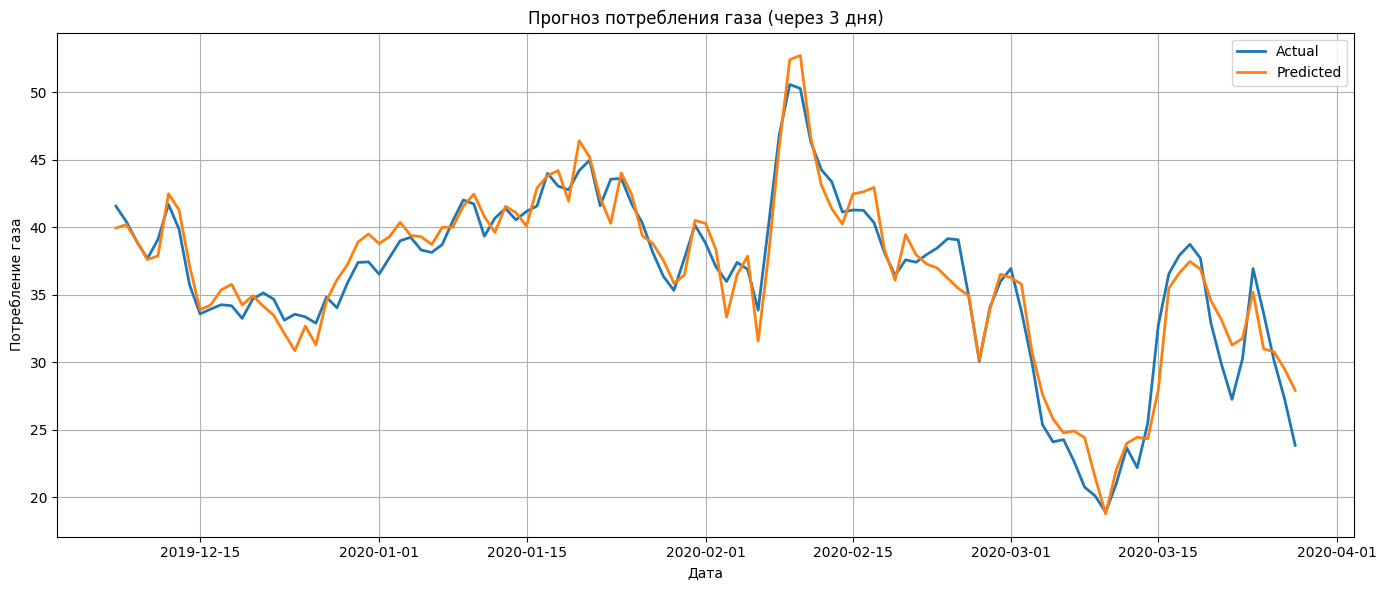

In [113]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


test_dates = df_model['Data'][-len(y_true_n):].reset_index(drop=True)


results_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates),
    'Actual': y_true_n,
    'Predicted': y_pred_n
})


plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', linewidth=2)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', linewidth=2)
plt.title('Прогноз потребления газа (через 3 дня)')
plt.xlabel('Дата')
plt.ylabel('Потребление газа')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [114]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


model_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
model_xgb.fit(X_train, y_train.ravel())

y_pred_xgb = model_xgb.predict(X_test)


y_pred_xgb = scaler_y.inverse_transform(y_pred_xgb.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test).flatten()


mape = mean_absolute_percentage_error(y_true, y_pred_xgb) * 100
rmse = np.sqrt(mean_squared_error(y_true, y_pred_xgb))

print(f"XGBoost → MAPE: {mape:.2f}%, RMSE: {rmse:.2f}")


XGBoost → MAPE: 3.72%, RMSE: 1.61


In [116]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error



model.eval()
with torch.no_grad():
    preds = []
    for xb, _ in test_loader:
        out = model(xb).squeeze().numpy()
        preds.append(out)


y_pred_fnn = np.concatenate(preds).reshape(-1, 1)
y_pred_fnn = scaler_y.inverse_transform(y_pred_fnn).flatten()


y_pred_ensemble = (y_pred_fnn + y_pred_xgb) / 2


y_true = scaler_y.inverse_transform(y_test).flatten()

mape = mean_absolute_percentage_error(y_true, y_pred_ensemble) * 100
rmse = np.sqrt(mean_squared_error(y_true, y_pred_ensemble))

print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")


MAPE: 3.66%
RMSE: 1.56


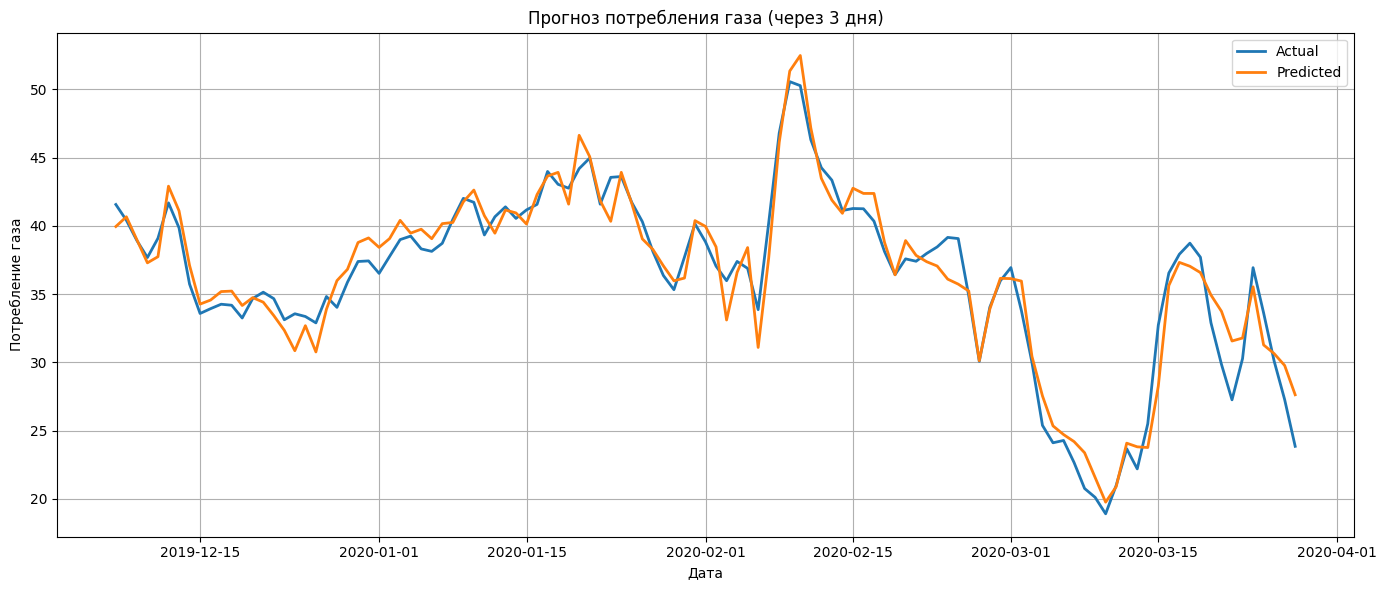

In [117]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

test_dates = df_model['Data'][-len(y_true):].reset_index(drop=True)


results_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates),
    'Actual': y_true,
    'Predicted': y_pred_ensemble
})


plt.figure(figsize=(14, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual', linewidth=2)
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted', linewidth=2)
plt.title('Прогноз потребления газа (через 3 дня)')
plt.xlabel('Дата')
plt.ylabel('Потребление газа')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


FCNN

In [118]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Целевой столбец
target_col = 'V_target'

# Dataset
class GasDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# DataLoaders
train_dataset = GasDataset(X_train, y_train)
test_dataset = GasDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [119]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim):
        super(FullyConnectedNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)


In [120]:
model = FullyConnectedNN(X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение
for epoch in range(100):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        preds = model(X_batch).squeeze()
        loss = loss_fn(preds, y_batch.squeeze())
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")


Epoch 0 | Loss: 0.00399
Epoch 10 | Loss: 0.00029
Epoch 20 | Loss: 0.00010
Epoch 30 | Loss: 0.00025
Epoch 40 | Loss: 0.00070
Epoch 50 | Loss: 0.00049
Epoch 60 | Loss: 0.00034
Epoch 70 | Loss: 0.00055
Epoch 80 | Loss: 0.00049
Epoch 90 | Loss: 0.00110


In [121]:
model.eval()
y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch).squeeze()
        y_preds.append(preds.numpy())
        y_true.append(y_batch.squeeze().numpy())

# Склеим все предсказания
y_preds = np.concatenate(y_preds)
y_true = np.concatenate(y_true)

# Обратное масштабирование
y_preds_inv = scaler_y.inverse_transform(y_preds.reshape(-1, 1)).flatten()
y_true_inv = scaler_y.inverse_transform(y_true.reshape(-1, 1)).flatten()

# Метрики
rmse = np.sqrt(mean_squared_error(y_true_inv, y_preds_inv))
mape = mean_absolute_percentage_error(y_true_inv, y_preds_inv)
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse:.3f}")



MAPE: 3.73%
RMSE: 1.587


prophet

In [123]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Копия и подготовка
df_prophet = df_model[['Data', 'V_target']].copy()
df_prophet.rename(columns={'Data': 'ds', 'V_target': 'y'}, inplace=True)

# Удалим пропуски
df_prophet = df_prophet.dropna().reset_index(drop=True)

# Разделение на train/test (последние 3 месяца = тест)
cutoff_date = df_prophet['ds'].max() - pd.Timedelta(days=113)
train_df = df_prophet[df_prophet['ds'] <= cutoff_date]
test_df = df_prophet[df_prophet['ds'] > cutoff_date]

# Создание и обучение модели Prophet
model = Prophet(
    daily_seasonality=True,
    yearly_seasonality=True,
    weekly_seasonality=True
)
model.fit(train_df)

# Прогнозируем на длину теста (90 дней)
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

# Объединим прогноз и тест
pred_df = forecast[['ds', 'yhat']].merge(test_df, on='ds', how='inner')

# Метрики
mape = mean_absolute_percentage_error(pred_df['y'], pred_df['yhat']) * 100
rmse = np.sqrt(mean_squared_error(pred_df['y'], pred_df['yhat']))

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_gin_rx/buyle9yg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_gin_rx/ttaumrlw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30957', 'data', 'file=/tmp/tmp6_gin_rx/buyle9yg.json', 'init=/tmp/tmp6_gin_rx/ttaumrlw.json', 'output', 'file=/tmp/tmp6_gin_rx/prophet_model6lu_c1yf/prophet_model-20250715114909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:49:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:49:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 13.88%
RMSE: 5.52


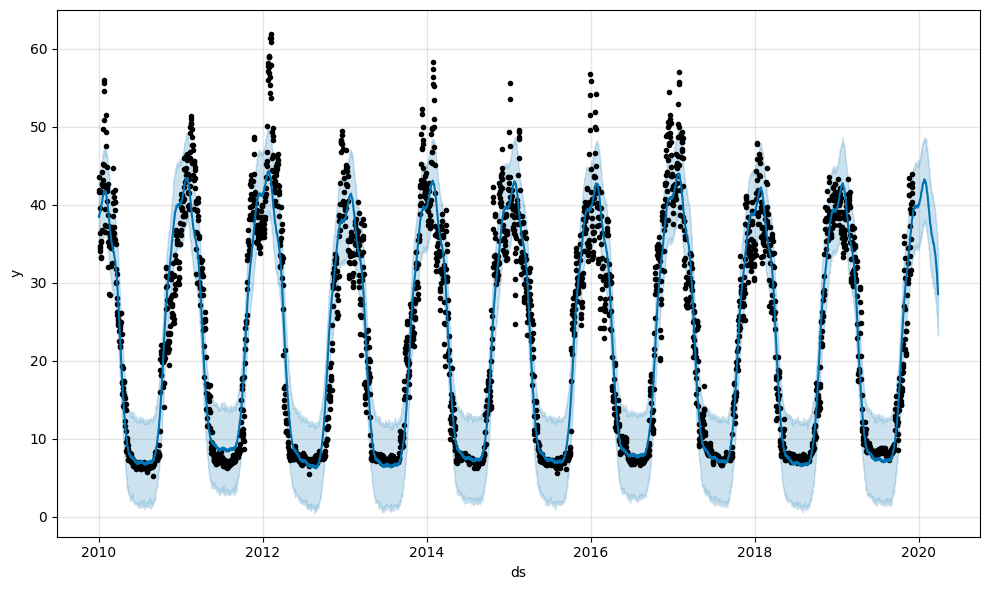

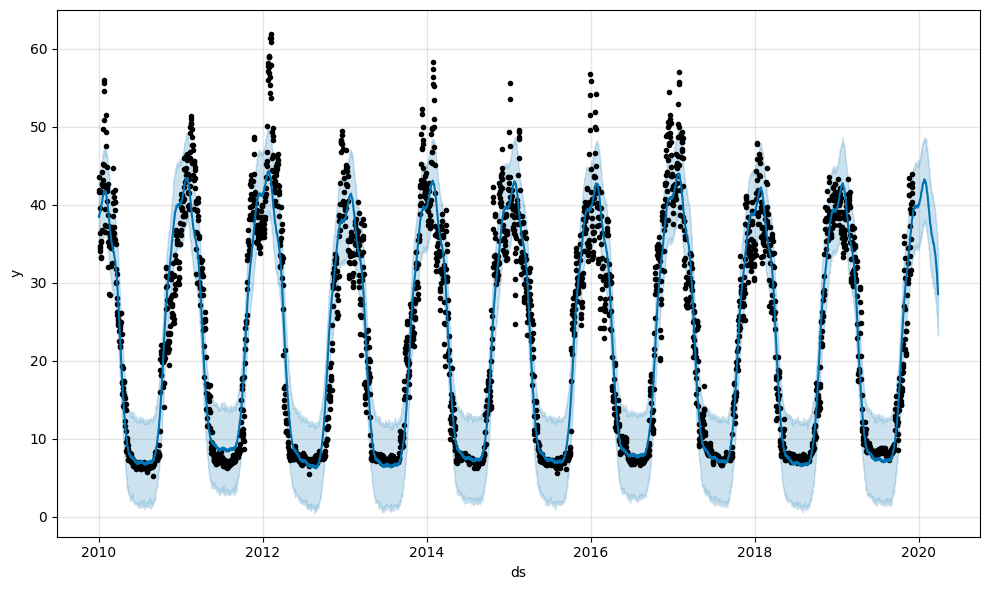

In [124]:
model.plot(forecast)

In [137]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
import pandas as pd

# Выбираем нужные столбцы
df_prophet = df_model[['V',	'T',
    'Data', 'V_target',
    'T_t+1', 'T_t+2', 'T_t+3','is_workday',	'is_weekend', 'is_shortday',	'is_holiday'
]].copy()

# Переименуем
df_prophet.rename(columns={'Data': 'ds', 'V_target': 'y'}, inplace=True)
df_prophet = df_prophet.dropna()

# Инициализация модели

model = Prophet(
    interval_width=0.95,
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=0.01,
    holidays_prior_scale=1.0,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'


)

#model.add_country_holidays(country_name='RU')
# Добавляем регрессоры
regressors = ['V',	'T','T_t+1', 'T_t+2', 'T_t+3','is_workday',	'is_weekend', 'is_shortday',	'is_holiday']
for reg in regressors:
    model.add_regressor(reg)

# Train/test split
cutoff_date = df_prophet['ds'].max() - pd.Timedelta(days=113)
train_df = df_prophet[df_prophet['ds'] <= cutoff_date]
test_df = df_prophet[df_prophet['ds'] > cutoff_date]

# Обучение модели
model.fit(train_df[['ds', 'y'] + regressors])

# Подготовка future с теми же регрессорами
future = test_df[['ds'] + regressors]

# Прогноз
forecast = model.predict(future)

# Сравнение
pred_df = forecast[['ds', 'yhat']].merge(test_df[['ds', 'y']], on='ds')
mape = mean_absolute_percentage_error(pred_df['y'], pred_df['yhat']) * 100
rmse = np.sqrt(mean_squared_error(pred_df['y'], pred_df['yhat']))

print(f'MAPE: {mape:.2f}%')
print(f'RMSE: {rmse:.2f}')


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_gin_rx/mrn8_7cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6_gin_rx/ijuwfubd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59934', 'data', 'file=/tmp/tmp6_gin_rx/mrn8_7cp.json', 'init=/tmp/tmp6_gin_rx/ijuwfubd.json', 'output', 'file=/tmp/tmp6_gin_rx/prophet_model73a8amdk/prophet_model-20250715115423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:54:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:54:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE: 4.52%
RMSE: 1.85


In [138]:
# Прогноз
forecast = model.predict(future)

# Оценка попадания в интервал
interval_df = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test_df[['ds', 'y']], on='ds')
interval_df['in_interval'] = (interval_df['y'] >= interval_df['yhat_lower']) & (interval_df['y'] <= interval_df['yhat_upper'])

coverage = interval_df['in_interval'].mean() * 100

print(f"Доля попаданий в интервал (95% доверительный): {coverage:.2f}%")


Доля попаданий в интервал (95% доверительный): 92.04%


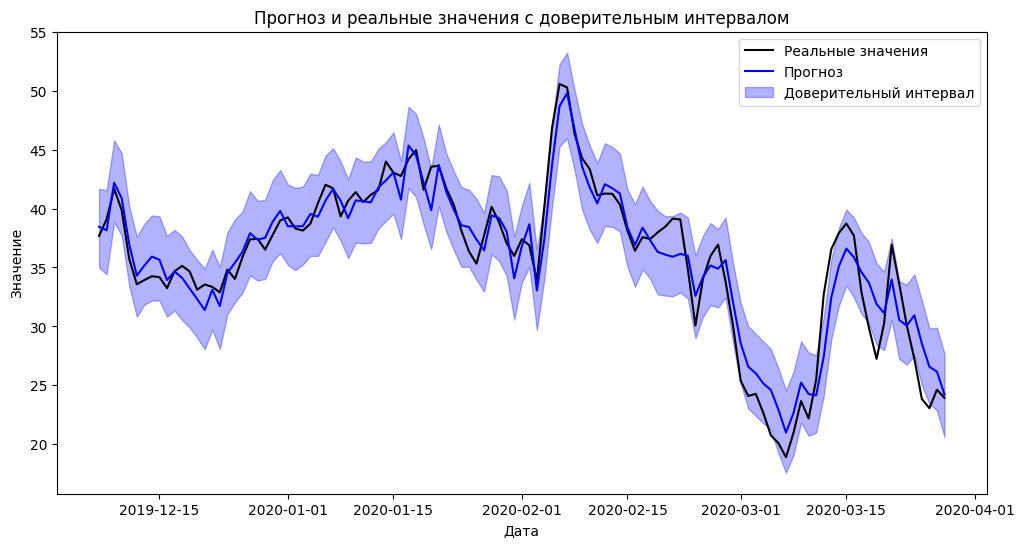

In [139]:
import matplotlib.pyplot as plt
# Добавим реальные значения в forecast
forecast = forecast.merge(test_df[['ds', 'y']], on='ds', how='left')

plt.figure(figsize=(12,6))

# Рисуем реальные значения
plt.plot(forecast['ds'], forecast['y'], label='Реальные значения', color='black')

# Рисуем прогноз
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз', color='blue')

# Заполняем область доверительного интервала
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='blue', alpha=0.3, label='Доверительный интервал')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Прогноз и реальные значения с доверительным интервалом')
plt.legend()
plt.show()


In [140]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','y']].head(10))

          ds       yhat  yhat_lower  yhat_upper          y
0 2019-12-07  38.449313   35.002338   41.683558  37.679617
1 2019-12-08  38.152532   34.425591   41.547425  39.091120
2 2019-12-09  42.193115   38.866385   45.791437  41.684987
3 2019-12-10  40.875904   37.703709   44.682403  39.855826
4 2019-12-11  36.954874   33.442722   40.184788  35.733283
5 2019-12-12  34.306788   30.813708   37.619213  33.577950
6 2019-12-13  35.163864   31.842999   38.693018  33.930234
7 2019-12-14  35.919384   32.185265   39.415439  34.255414
8 2019-12-15  35.656983   32.195173   39.336479  34.181475
9 2019-12-16  33.936609   30.842374   37.676606  33.244816


In [141]:
# Убедимся, что длины совпадают
min_len = min(len(forecast), len(y_pred_r))

# Обрезаем до минимального размера
forecast_trimmed = forecast.iloc[:min_len].copy()
y_pred_r_trimmed = y_pred_r[:min_len]


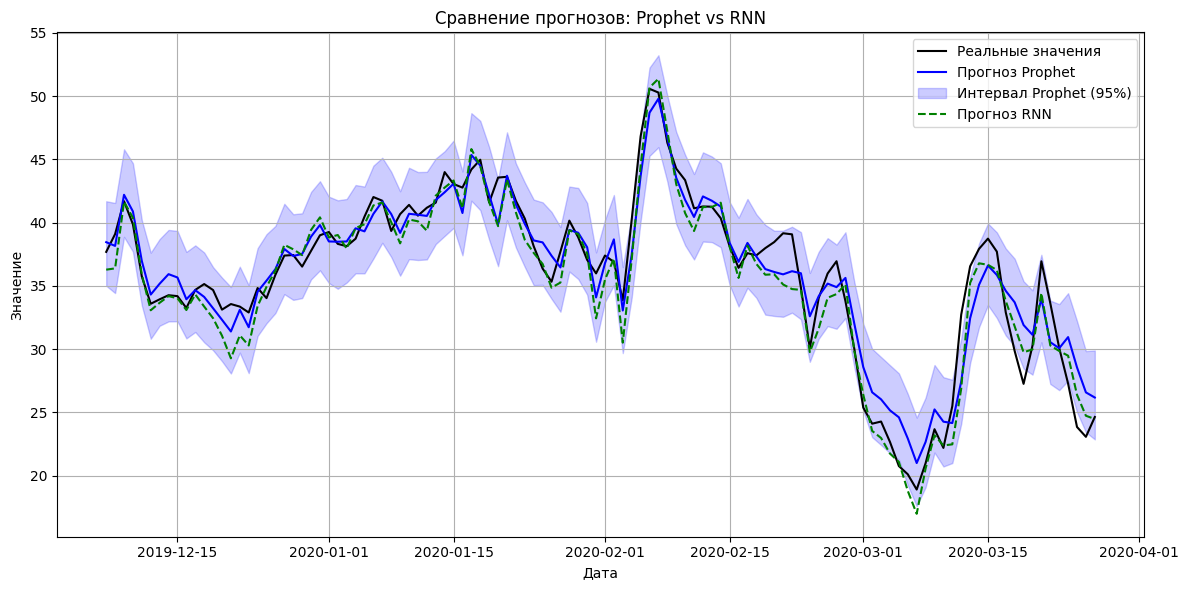

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Реальные значения
plt.plot(forecast_trimmed['ds'], forecast_trimmed['y'], label='Реальные значения', color='black')

# Прогноз Prophet
plt.plot(forecast_trimmed['ds'], forecast_trimmed['yhat'], label='Прогноз Prophet', color='blue')

# Доверительный интервал Prophet
plt.fill_between(
    forecast_trimmed['ds'],
    forecast_trimmed['yhat_lower'],
    forecast_trimmed['yhat_upper'],
    color='blue', alpha=0.2,
    label='Интервал Prophet (95%)'
)

# Прогноз RNN
plt.plot(forecast_trimmed['ds'], y_pred_r_trimmed, label='Прогноз RNN', color='green', linestyle='--')

plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Сравнение прогнозов: Prophet vs RNN')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
